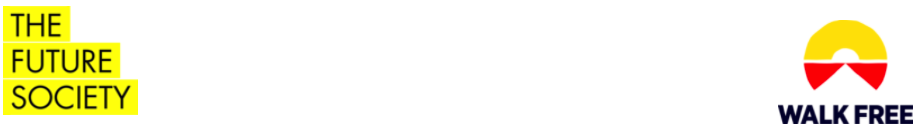

#*Project AIMS (AI against Modern Slavery)*
---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1R32-fNb8PzC1ix2Dl4o1MGNe0B5QSPiv/view?usp=sharing).

# Training metric


## Does the statement describe training of any kind for staff that is specifically geared towards detecting signs of slavery or trafficking?


The goal of this task is to check if the companies provide descriptions about training to their staff on modern slavery. Training is important for raising awareness and understanding the importance of modern slavery issues. It helps employees and suppliers identify the risks of modern slavery, and how to address such risks if they find them. Training can be targeted at specific groups of employees, especially those working in procurement, those who deal with supply chains or recruitment or are in leadership positions. The training can be in any form (face-to-face or online) but should explicitly address modern slavery.
 
This training can take place as a standalone course on modern slavery or be embedded in a wider training program on supply chains or human rights. It can cover many different groups- procurement specialists and those who work in recruitment or leadership positions.
 
For more information, please refer to [WikiRate's UK Modern Slavery Act Research on MSA training (revised) metric ](https://wikirate.org/Walk_Free_Foundation+MSA_training_revised) or [Home Office Guidance on pp. 37.](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf)
 
### Labelled dataset
We are working with the initially categorical labels that we converted to binary. More specifically, if the training is targeting those who work in recruitment or human resources, the annotators selected the 'Recruitment/ HR' value. If the leadership or management of the company receives training, they select the 'Leadership' label. If the training is provided to suppliers and/or contractors, the statement was labelled with 'Suppliers' value. If all employees in the company are receiving training, then the label 'Employees (all)' was given to the statement. Similarly, where the recipients of the training are not specified, the label used was the 'Training provided- not specified' value.
If any of those labels were associated with the statement, for this task, the statement was assigned positive class label '1'.
 
If the business indicates it is 'developing' a training program or 'plans to implement one in the future', the annotators labelled the statement with the  'In Development' label. They also selected 'No' as a label if no training is described in the statement. If any of those cases are present, the statement was assigned the negative class label '0' for this task.
 


In [ ]:
#!pip install snorkel
#!pip install unidecode
#!pip install contractions
#!pip install eli5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

[Errno 2] No such file or directory: '/content/drive/MyDrive/ProjectAIMS'
/content


## Setup

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import re
import snorkel
from snorkel.labeling import labeling_function, PandasLFApplier
from sklearn.metrics import classification_report
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import eli5
import nltk
import nltk.data
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from IPython.display import HTML as html_print

from utils import sentencizer, evaluation_rb
from utils.preprocessing import *

ModuleNotFoundError: ignored

### 🗄️ You can access the data used in this notebook [here ](https://drive.google.com/file/d/16gWHC4QOhzQ2EIad6YsQVYqzs0ZK2vZg/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://drive.google.com/file/d/16gWHC4QOhzQ2EIad6YsQVYqzs0ZK2vZg/view?usp=sharing).

In [ ]:
metric ='Walk Free Foundation+MSA training (revised)'   #metric that we need to label
file_name = 'approval_training_binary.csv'

data = load_dataset(metric, file_name) # load and remove duplicates and empty cells in TEXT and Label columns

Number of available statements for Walk Free Foundation+MSA training (revised) -> 875



In [ ]:
data[metric] = data[metric].astype(int)
print("Final number of data points in the labeled dataset is:")
print(data[metric].value_counts())

Final number of data points in the labeled dataset is:
1    655
0    220
Name: Walk Free Foundation+MSA training (revised), dtype: int64


## Preprocessing

Some basic steps to pre-process statements are performed which include: 
- lemmatisation 
- remove company names
- fix contractions (contraction is a shortened version of the spoken and written forms of a word)
- remove empty lines
- remove accents
- remove punctuation
- normalize text

In [ ]:
preprocessing = Preprocessing()
data['clean_text'] = data.TEXT.apply(lambda row: preprocessing(row))

Preprocessing...


In [ ]:
def print_side_by_side(str1, str2, size=30, space=4):
    while str1 or str2:
        print(str1[:size].ljust(size) + " " * space + str2[:size])
        str1 = str1[size:]
        str2 = str2[size:]


print_side_by_side(data.TEXT[0][:500], data.clean_text[0][:500])

Slavery and human trafficking     slavery and human trafficking 
statement 2018
1. Introduction    statement 2018 1 . introductio
 2. About our business 3. Our     n 2 . about business 3 . code 
code and human rights policy 4    and human right policy 4 . mod
. Modern slavery and our gover    ern slavery and governance 5 .
nance 5. Training 6. Assessing     train 6 . assess the risk of 
 the risk of modern slavery 7.    modern slavery 7 . manage mode
 Managing modern slavery risks    rn slavery risk 8 . work with 
 8. Working with others 9. Loo    other 9 . look ahead c 2019 sl
king ahead
© BP 2019

Slavery    avery and human trafficking st
 and human trafficking stateme    atement 2018 this statement re
nt 2018

This statement relate    late to the financial year end
s to the financial year ending     31 december 2018 . be publish
 31 December 2018. It is publi     by . and relevant subsidiarie
shed by BP p.l.c. and its rele    s1 in compliance with the uk m
vant subsidiaries1 in com

## Synonyms

For the labeling purpose, the synonyms of ‘slavery’, ‘training’ and contrasting connectors are taken into consideration. For example,  ‘slavery’ can be written as 'enslavement', 'servitude', 'subjugation', 'trafficking', 'forced labor', ‘forced labor’, ‘child labor’, ‘child labor’ and ‘training’ can be written as 'coaching', 'guidance', 'instruction', 'training', 'trained', 'educating'. 

In [ ]:
synonyms_modern = ['modern']
synonyms_slavery = ['slavery', 'forced labor',"forced labour", "child labor", "child labour"]
synonyms_training = ['coaching', 'guidance', 'instruction', 'training', "trained", "educating"]

connectors = ['however', 'nevertheless']



dic_all_terms = {'modern':synonyms_modern,
              'slavery':synonyms_slavery,
              'training': synonyms_training,
              'connectors': connectors}


In [ ]:
for key, list_terms in dic_all_terms.items():
    list_syns = []
    for term in list_terms:
         for syn in wordnet.synsets(term):
            for l in syn.lemmas():
                list_syns.append(l.name())
    print(key, set(list_syns))

modern {'modernistic', 'Bodoni_font', 'modern_font', 'innovative', 'Modern', 'mod', 'Bodoni', 'New', 'advanced', 'forward-looking', 'modern'}
slavery {'thraldom', 'slavery', 'thrall', 'slaveholding', 'bondage', 'thralldom'}
training {'coaching', 'prepare', 'cultivate', 'take', 'direct', 'aim', 'school', 'rail', 'preparation', 'steering', 'pedagogy', 'coaching_job', 'instruction', 'program_line', 'educate', 'trained', 'counselling', 'civilize', 'grooming', 'condition', 'discipline', 'take_aim', 'coach', 'check', 'direction', 'counseling', 'develop', 'statement', 'train', 'didactics', 'civilise', 'counsel', 'training', 'trail', 'guidance', 'teaching', 'education', 'educational_activity', 'command', 'groom', 'breeding'}
connectors {'all_the_same', 'notwithstanding', 'yet', 'even_so', 'however', 'nonetheless', 'still', 'withal', 'nevertheless'}


Out of the generated synonyms we select those that seem the most appropriate for the corpus.

In [ ]:
synonyms_slavery_extended = [
    'slavery', 
    'enslavement',
    'servitude',
    'subjugation',
    'trafficking', 
    'forced labor',
    'forced labour', 
    'child labor', 
    'child labour',
    'captivity', 
    'opression',
    'bondage',
    'slaveholding',
    'modern slavery act',
    'msa'
]
synonyms_training_extended = 
    [
    'coach',
    'guidance',
    'instruction', 
    'training', 
    'trained',
    'educating',
    'counselling',
    'program line', 
    'teaching',
    'educate'
    ]

connectors_extended = 
    [
    'nevertheless',
    'notwithstanding', 
    'yet', 
    'however',
    'nonetheless',
    'even so'
    ]


list_context_words = 
    [
    'training',
    'course on modern slavery',
    'training programme',
    'procurement',
    'purchasing',
    'training provider',
    'intranet',
    'e-module',
    'e-learning',
    'toolkit',
    'roll out',
    'workshop',
    'targeted training'
    ]

In [ ]:
dic_final_terms = {
                  'slavery': synonyms_slavery_extended,
                  'training': synonyms_training_extended,
                  'connectors': connectors_extended
                  }


for key, val in dic_final_terms.items():
    dic_final_terms[key] = lemmatize_keywords(val)

In [ ]:
list_context_words = lemmatize_keywords(list_context_words)
regex_context_words = re.compile('|'.join(list_context_words))
dic_final_terms['context'] = regex_context_words

## Labelling functions

The next step is to check if the key phrases are present in a particular statement of a company.  Two labelling functions are created to check statements with synonyms of keywords ‘slavery’ and ‘training’. Utilities from the Snorkel library like LFAnalysis are used to evaluate these labelling tasks. After collecting statistics about LFAnalysis, MajorityLabelVoter is used to perform the classification task to predict the label. The predicted variables are evaluated against their respective ground-truth value.
The output of the system is a prediction about whether a sentence could be classified as containing relevant information about the training or not.
 


In [ ]:
#helper functions for the labeling functions

def get_previous_next_sent(list_sent, sent_num):
    try:
        return list_sent[sent_num-1], list_sent[sent_num+1]
    except:
        None
        
def check_keyword(keyword_type, sent):
    return any(keyword in sent for keyword in dic_final_terms[keyword_type])

def check_all_elements(sent):
    if check_keyword('training', sent): #training keyword search
        if not check_keyword('connectors', sent): #make sure no opposition was found
            sent_tense = tense(sent)
            if sent_tense["future"]==0: #make sure the sentence is not in future tense 
                return YES
    
    return None
                 
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    return(tense)
    

In [ ]:
NO = 0
YES = 1

@labeling_function()
def keywords_search(x): 
  
    sentences = sentencizer.main((str(x.TEXT).strip()))
    list_sent = [sent.lower() for sent in sentences]
    
    
    for i,sent in enumerate(list_sent):
        if check_keyword('slavery', sent):
            
            if get_previous_next_sent(i, list_sent) != None:
                prev_sent, next_sent = get_previous_next_sent(i, list_sent)
                prev_s = check_all_elements(prev_sent)
                current_s = check_all_elements(sent)
                next_s = check_all_elements(next_sent)

                if any([prev_s, current_s, next_s]== YES):
                    return YES
                else:
                    continue      
            
            else:
                current_s = check_all_elements(sent)
                if current_s:
                    return YES
                else:
                    continue
            
    return NO

            
@labeling_function()
def context_search(x, threshold = 3):   
    sentences = sentencizer.main((str(x.TEXT).strip()))
    list_sent = [sent.lower() for sent in sentences]
    
    for i in range(3, len(list_sent), 3):
    
        found_elements = re.findall(dic_final_terms['context'], "".join(list_sent[:i+1]))
        if len(found_elements)>3:
            return YES
        
    return NO


In [ ]:
lfs = [keywords_search, context_search]
applier = PandasLFApplier(lfs)
L_train = applier.apply(data, progress_bar = True)

majority_model = MajorityLabelVoter()

100%|██████████| 875/875 [35:32<00:00,  2.44s/it]  


In [ ]:
predicted_labels = majority_model.predict(L=L_train) 
predicted_labels = [1 if v == -1 or v==1 else 0 for v in predicted_labels]

In [ ]:
coverage_training_metric = (L_train == YES).mean(axis=0)
print()
print(f"keywords_search: positive label is assigned to {int(coverage_training_metric[0]*100)}% of the statements.")
print(f"context_search: positive label is assigned to {int(coverage_training_metric[1]*100)}% of the statements.\n\n")


keywords_search: positive label is assigned to 45% of the statements.
context_search: positive label is assigned to 42% of the statements.


                  j Polarity  Coverage  Overlaps  Conflicts
training_search1  0   [0, 1]       1.0       1.0   0.330286
training_search2  1   [0, 1]       1.0       1.0   0.330286


#Results

Evaluation of the rule-based model


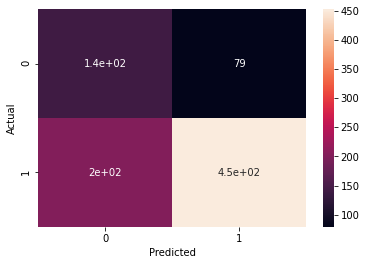

Confusion Matrix:
 [[141  79]
 [202 453]]
Accuracy Score: 0.6788571428571428
Precision Score: 0.7407683202174533
Recall Score: 0.6788571428571428
F1 Score: 0.6972987539245147


In [ ]:
evaluation_rb.main(data[metric], y_predicted_maj)

In [ ]:
print(classification_report(y_true, y_predicted_maj))

              precision    recall  f1-score   support

           0       0.41      0.64      0.50       220
           1       0.85      0.69      0.76       655

    accuracy                           0.68       875
   macro avg       0.63      0.67      0.63       875
weighted avg       0.74      0.68      0.70       875



We have achieved 68% overall accuracy, 74% precision, and 67% recall using this method. Higher scores of precision and recall in the positive class were achieved, which is also likely impacted by the imbalanced distribution of the original data.
 

In [ ]:
def generate_output_func1(row):   
   
    """ Extract sentence justifying assigned label for keywords_search function
        
        :param : row - row containing statement to be labeled
        :return: set of extracted sentences
    """
    sentences = sentencizer.main((str(row.TEXT).strip()))
    list_sent = [sent.lower() for sent in sentences]
    
    result = []
    for i, sent in enumerate(list_sent):
        if check_keyword('slavery', sent):
            
            if get_previous_next_sent(i, list_sent) != None:
                prev_sent, next_sent = get_previous_next_sent(i, list_sent)
                prev_s = check_all_elements(prev_sent)
                current_s = check_all_elements(sent)
                next_s = check_all_elements(next_sent)

                if prev_s == YES:
                    result.append(prev_sent)
                if current_s == YES:
                    result.append(sent)
                if next_s == YES:
                    result.append(next_sent)
                else:
                    continue
            
            
            else:
                current_s = check_all_elements(sent)
                if current_s:
                    result.append(sent)
                else:
                    continue
    
    return set(result)
                         
    
def generate_output_func2(row, threshold = 3):
    
    """ Extract sentence justifying assigned label for context_search function
        
        :param : row - row containing statement to be labeled
        :return: set of extracted sentences
    """
        
    sentences = sentencizer.main((str(row.TEXT).strip()))
    list_sent = [sent.lower() for sent in sentences]
    result = []
    
    for i in range(threshold, len(list_sent), threshold):
    
        found_elements = re.findall(dic_final_terms['context'], "".join(list_sent[:i+1]))
        if len(set(found_elements))>3:
            result.append("".join(list_sent[:i+1]))
        
    return set(result)

In [ ]:
generate_output_func1(data.TEXT[0])

{'to reach more of our employees around the world, in 2018 we converted our training on labour rights and modern slavery risk into e-modules.',
 'we also began to develop guidance to help bp businesses and functions in their dialogue and collaboration with civil society organizations and other third parties, in support of risk management or capability development activities relating to modern slavery in our priority countries.\n',
 'we continue to collaborate with ipieca, our industry association for environmental and social issues, to develop guidance and tools to support the industry and our contractors to address labour rights risks, including modern slavery, at large operating sites.',
 'we provided training to nearly 400 people in 2018, covering what human rights means in an operational context, as well as specific topics including labour rights and modern slavery.'}

In [ ]:
generate_output_func2(data.TEXT[0])

set()

## Logistic regression 

In [ ]:
df = data[['clean_text', metric]]

train, valid, test = \
                np.split(df.sample(frac=1, random_state=42), 
                        [int(.8*len(df)), int(.9*len(df))])

print("Number of training examples:", train.shape[0])

Number of training examples: 700


In [ ]:
train_val = pd.concat([train, valid])
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features = 10000 )

In [ ]:
%%time
X_train_text = text_transformer.fit_transform(train_val['clean_text'])
X_test_text = text_transformer.transform(test['clean_text'])

CPU times: user 2.96 s, sys: 90.7 ms, total: 3.05 s
Wall time: 3.09 s


In [ ]:
logit = LogisticRegression(C=5e1, solver='lbfgs', random_state=17, n_jobs=4)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [ ]:
%%time
logit.fit(X_train_text, train_val[metric])

CPU times: user 18.7 ms, sys: 9.22 ms, total: 27.9 ms
Wall time: 568 ms


LogisticRegression(C=50.0, n_jobs=4, random_state=17)

As expected training is the word with the highest weight.

In [ ]:
eli5.show_weights(estimator=logit, 
                  feature_names= list(text_transformer.get_feature_names()),
                 top=(50, 5))

# words from corpus with the highest weight for positive and negative classes.

Weight?,Feature
+9.094,training
+4.209,manager
+3.929,resource
+3.390,version
+3.376,aprirose
+3.283,clear
+3.168,traffic
+3.063,tier
+2.999,induction
+2.991,training provide


Both labelling functions and the first round of experiments with Logistic Regression yields similar results.